# Chapter 1: Umbrella sampling

#### Author
Wei-Tse Hsu
- University of Colorado Boulder
- www.weitsehsu.com
- wehs7661@colorado.edu
- [@WeiTseHsu](https://twitter.com/WeiTseHsu)

This is a hands-on tutorial that corresponds to Section 2 of [Chapter 1: Umbrella sampling](https://weitsehsu.com/course/enhanced_sampling/us/) in the course of [Hands-on tutorials: Enhanced sampling methods using GROMACS](https://weitsehsu.com/course/enhanced_sampling/). To keep this notebook succinct, here we will not repeat the content of the article but only show the results of code execution. For more comprehensive discussions about the method, please visit the accompanying article linked above. (Or check my website for more future posts/tutorials about enhanced sampling methods!)

## 1. Setting things up

In [1]:
%%bash
dirs=(sim_* pull* *mdp *dat results)
for dir in "${dirs[@]}"; do
    if ls -d "$dir" >/dev/null 2>&1; then
        rm -rf "$dir"
    fi
done

## 2. Pulling simulation

In [2]:
%%bash
mkdir pull

### 2.1. Modification of the `top` file

In [3]:
%%bash
cat ../Systems/NaCl/NaCl.top

#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1


In [4]:
%%bash 
echo '#include "oplsaa.ff/forcefield.itp"
#include "oplsaa.ff/tip3p.itp"

[ moleculetype ]
; molname   nrexcl
CL      1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_401    1       CL          CL       1      -1       35.45300

[ moleculetype ]
; molname   nrexcl
NA          1

[ atoms ]
; id    at type     res nr  residu name at name  cg nr  charge   mass
1       opls_407    1       NA          NA       1      1        22.98977

; position restraints for Na
# ifdef POSRES_NA
# include "Na_posres.itp"
# endif

[ System ]
NaCl in water

[ Molecules ]
SOL         107
NA               1
CL               1' > pull/NaCl_US.top

In [5]:
%%bash 
cp ../Systems/NaCl/NaCl.gro pull/.    # copy over the gro file by the way
echo '[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000' > pull/Na_posres.itp

### 2-2. Modification of the `mdp` file

In [6]:
%%bash
cat ../Systems/NaCl/MD-NVT.mdp  # the original MDP file

integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
DispCorr = AllEnerPres
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000


In [7]:
%%bash
echo 'define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 125000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000
' > pull/NaCl_pull.mdp
# Here we create an mdp file starting with `define=-DPOSRES_NA`

In [8]:
%%bash
echo '; Pull code
pull = yes                        ; Activate the pull code
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 pull groups
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; The umbrella potential (i.e., harmonic potential) is used.
pull-coord1-geometry = distance   ; Increase the distance between the pull groups
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           ; The harmonic potential is centered at the initial COM distance. 
pull-coord1-rate = 0.0010         ; 0.0010 nm/ps -> pull distance in the 250 ps-simulation: 0.25 nm.
pull-coord1-k = 1000              ; units: kJ/mol/nm^2' >> pull/NaCl_pull.mdp

### 2-3. Running a pulling simulation

In [9]:
%%bash
mpirun -np 1 gmx_mpi grompp -f pull/NaCl_pull.mdp -c pull/NaCl.gro -r pull/NaCl.gro -p pull/NaCl_US.top -o pull/pull.tpr -po pull/mdout.mdp -maxwarn 1

               :-) GROMACS - gmx grompp, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

Setting the LD random seed to -73413633

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -411140237

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file pull/NaCl_pull.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 5 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.280 nm          0.280 nm

There was 1 note

GROMACS reminds you: "We can make it into a friend class. But I don't like having friends." (Joe Jordan)



In [10]:
%%time
%%bash
mpirun -np 1 gmx_mpi mdrun -deffnm pull/pull -pf pull/pullf.xvg -px pull/pullx.xvg -ntomp 1

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

CPU times: user 83 ms, sys: 11.5 ms, total: 94.5 ms
Wall time: 43.6 s


### 2-4. Generation of the initial configurations

In [11]:
import numpy as np
pullx = np.transpose(np.loadtxt('pull/pullx.xvg', comments=['@', '#']))
t, dist = pullx[0], pullx[1]
centers = np.linspace(min(dist), 0.6, 8)  # the spacing between windows should be around 0.05 nm
diff_list = np.abs([dist - i for i in centers])
diff_idx = [np.argmin(diff_list[i]) for i in range(len(centers))]  # dist[diff_idx]: distances closet to the centers
t_extract = t[diff_idx]  # in ps
print(f'The ion-pair distances (in nm) of the chosen configurations are: {dist[diff_idx]}')
print(f'The initial configurations will be extracted from the following time frames (in ps): {t_extract}')

The ion-pair distances (in nm) of the chosen configurations are: [0.251031 0.300954 0.35087  0.400397 0.450359 0.50036  0.550197 0.598224]
The initial configurations will be extracted from the following time frames (in ps): [ 94.   95.   52.2 114.2 204.2 202.1 165.4 190.7]


In [12]:
import os
for i in range(len(t_extract)):
    os.mkdir(f'sim_{i}')
    os.system(f'echo System | mpirun -np 1 gmx_mpi trjconv -s pull/pull.tpr -f pull/pull.xtc -dump {t_extract[i]} -o sim_{i}/NaCl_{i}.gro')

               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx trjconv, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            T

## 3. Production runs

In [13]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
sed -i -e "s/pull-coord1-k = 1000              ; units: kJ\/mol\/nm^2/pull-coord1-k = 8000/g" NaCl_umbrella.mdp
cat NaCl_umbrella.mdp

define=-DPOSRES_NA
integrator = md 
dt = 0.002
nsteps = 250000
cutoff-scheme = Verlet
coulombtype = PME
rlist = 0.6
rcoulomb = 0.6
rvdw = 0.6
constraints = h-bonds
tcoupl =  V-rescale
ref_t = 300
tau-t = 1.0
tc-grps = System
gen-vel = yes
gen-temp = 300
gen-seed = -1 
compressibility = 4.5e-5
nstxout-compressed = 50
nstxout = 50000
nstvout = 50000

; Pull code
pull = yes                        ; Activate the pull code
pull-ncoords = 1                  ; Here we only have 1 CV.
pull-ngroups = 2                  ; We have 2 pull groups
pull-group1-name = NA             ; index 1
pull-group2-name = CL             ; index 2
pull-coord1-groups = 1 2          ; groups with indices 1 (NA) and 2 (CL) are involved
pull-coord1-type = umbrella       ; The umbrella potential (i.e., harmonic potential) is used.
pull-coord1-geometry = distance   ; Increase the distance between the pull groups
pull-coord1-dim = Y Y Y           ; We allow pulling from any directions.
pull-coord1-start = yes           

In [14]:
%%bash
for i in {0..7}
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -maxwarn 1  # Generate the tpr
    mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

               :-) GROMACS - gmx grompp, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

Setting the LD random seed to -590390609

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -1073784977

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.251 nm          0.251 nm

There was 1 note

GROMACS reminds you: "The Lord of the Rings can be confusing to follow because many of the bad minions look and sound familiar; that's why Tolkien gave them each an ORCid." (Caroline Bartman)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov 

Setting the LD random seed to 2146414433

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -648586371

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.1

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.301 nm          0.301 nm

There was 1 note

GROMACS reminds you: "Screw a Lightbulb in your Head" (Gogol Bordello)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson              

Setting the LD random seed to 1609547197

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -134250770

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.1

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.350 nm          0.350 nm

There was 1 note

GROMACS reminds you: "There is an infinite set A that is not too big." (John von Neumann)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter K

Setting the LD random seed to -541246995

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -411304323

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.1

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.400 nm          0.400 nm

There was 1 note

GROMACS reminds you: "Everybody Lie Down On the Floor and Keep Calm" (KLF)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson          

Setting the LD random seed to -18894849

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -226608129

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.1

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.451 nm          0.451 nm

There was 1 note

GROMACS reminds you: "A cop pulls Heisenberg over and asks him 'Do you know how fast you were going?' Heisenberg replies 'No, but I know exactly where I am'. The cop says 'You were doing 55 in a 35 zone'. Heisenberg: 'Great! Now I'm lost!" (Anonymous)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hind

Setting the LD random seed to 1056763382

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -54530099

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.10

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.500 nm          0.500 nm

There was 1 note

GROMACS reminds you: "Humans are allergic to change. They love to say, 'We've always done it this way.' I try to fight that. That's why I have a clock on my wall that runs counter-clockwise." (Grace Hopper)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      A

Setting the LD random seed to -1333796243

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 1677713403

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.551 nm          0.551 nm

There was 1 note

GROMACS reminds you: "These Gromacs Guys Really Rock" (P.J. Meulenhoff)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson             

Setting the LD random seed to -810562569

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 1778293437

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.1

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.598 nm          0.598 nm



Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data



There was 1 note

GROMACS reminds you: "The Lord of the Rings can be confusing to follow because many of the bad minions look and sound familiar; that's why Tolkien gave them each an ORCid." (Caroline Bartman)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten K

## 4. Data analysis

### 4-1. Distributions of the pulling distance 

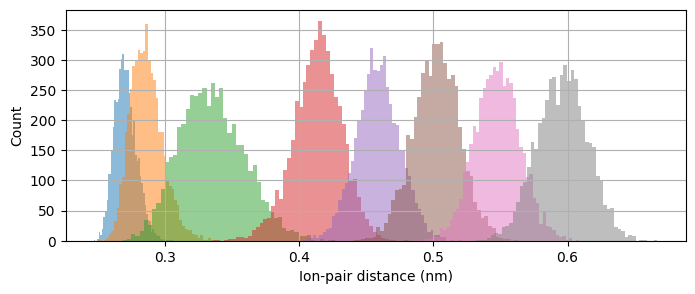

In [15]:
import matplotlib.pyplot as plt
pullx_data = [np.transpose(np.loadtxt(f'sim_{i}/pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]

plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{
    'family': 'sans-serif',
    'sans-serif': ['DejaVu Sans'],
    'size': 10,
})
# Set the font used for MathJax - more on thiprint(images)
rc('mathtext', **{'default': 'regular'})
plt.rc('font', family='serif')

In [19]:
def setup_coordinates(ax, color):
    """
    A function for setting the colors of axes and ticks for a plot. 
    This is just for producing figures for the article accompanying this tutorial.
    """
    ax.spines['top'].set_color(color)
    ax.spines['bottom'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(color=color, labelcolor=color)

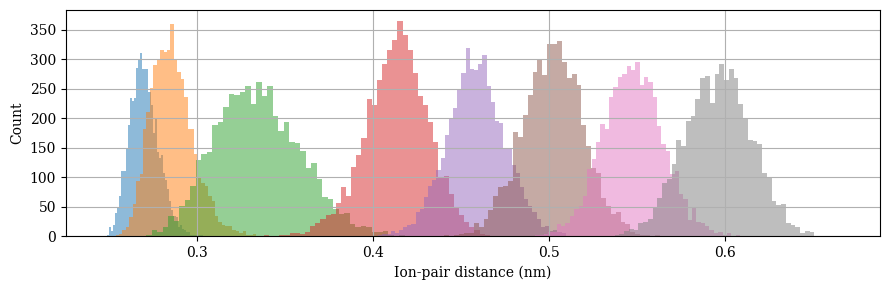

In [22]:
pullx_data = [np.transpose(np.loadtxt(f'sim_{i}/pullx.xvg', comments=['@', '#'])) for i in range(8)]
dist_list = [data[1] for data in pullx_data]
os.makedirs('results')

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(111)
# setup_coordinates(ax, color='white')
for i in range(8):
    plt.hist(dist_list[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()
plt.tight_layout()
plt.savefig('results/pullx_distribution.png', transparent=True, dpi=600)

### 4-2. Free energy calculations

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


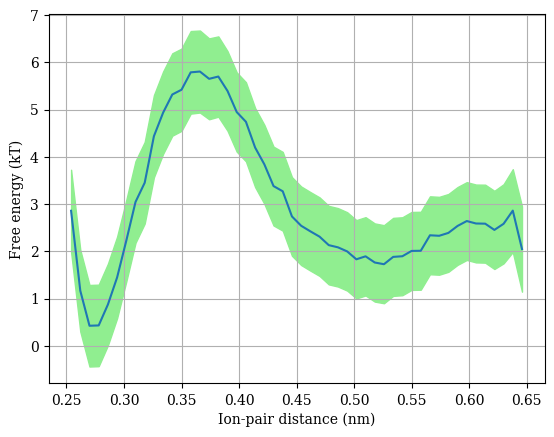

In [24]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 50                                  # number of bins for FES
K_k = np.ones(K) * 8000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('results/fes.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

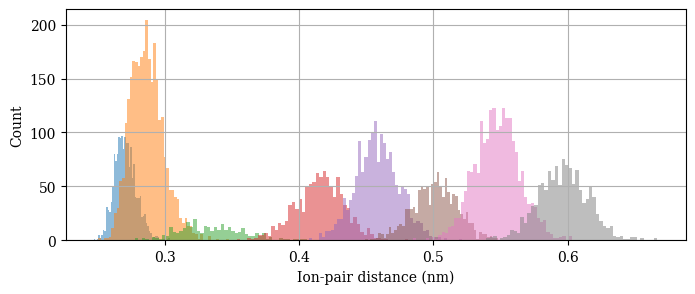

In [25]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

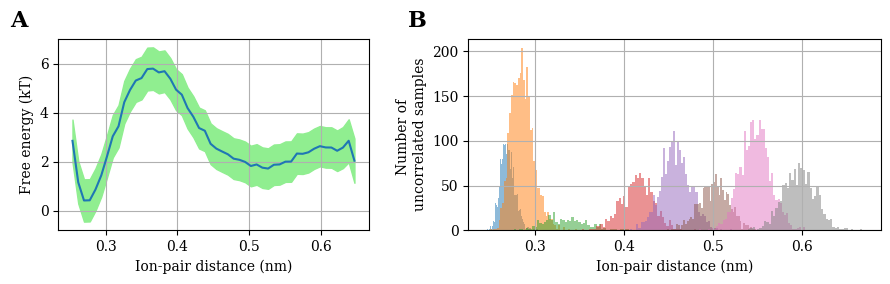

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a 3-row x 9-column grid
gs = gridspec.GridSpec(nrows=3, ncols=9)

# Create the first subplot of size 4:3 
plt.figure(figsize=(9, 3))
ax1 = plt.subplot(gs[:, 0:4])
ax1.plot(bin_center_i, f_i)
ax1.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
ax1.set_xlabel('Ion-pair distance (nm)')
ax1.set_ylabel('Free energy (kT)')
ax1.grid()
plt.text(-0.1, 1.15, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right', fontsize=16)

# Create the second subplot of size 8:3
ax2 = plt.subplot(gs[:, 4:9])
for i in range(8):
    ax2.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
ax2.set_xlabel('Ion-pair distance (nm)')
ax2.set_ylabel('Number of \nuncorrelated samples')
ax2.grid()
plt.text(-0.1, 1.15, 'B', transform=ax2.transAxes, fontweight='bold', va='top', ha='right', fontsize=16)

# setup_coordinates(ax1, color='white')
# setup_coordinates(ax2, color='white')
plt.tight_layout(w_pad=2)
plt.savefig('results/f_profile.png', transparent=True, dpi=600)

## 5. Additional exercises
In this section, we explore umbrella sampling simulations with different force constants to see how force constants change the spread of the CV distributions and the resulting free energy profile. For a more detailed description of the exercise, please refer to Exercise 3 in the article. 

### 5-1. Setting $k$ to $1000$ $\mathrm{kJ/mol/nm^2}$

In [27]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
# no need to modify k since k=1000 was also used in the pulling simulation

In [32]:
%%bash
nproc

72


In [29]:
%%bash
for i in {0..5}    # We only run simulations for 6 windows here, since the centers of the last two windows are too close to the upper bound. 
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -maxwarn 1  # Generate the tpr
    # mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

               :-) GROMACS - gmx grompp, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

Setting the LD random seed to -136126657

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -566272289

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...


Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00



Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.106

Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data



NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.251 nm          0.251 nm

There was 1 note

Back Off! I just backed up NaCl_US.tpr to ./#NaCl_US.tpr.1#

GROMACS reminds you: "Since the mathematicians have invaded the theory of relativity I do not understand it myself any more." (Albert Einstein)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert

Setting the LD random seed to 2071198463

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to -1904345091

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.




Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data


Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.301 nm          0.301 nm

There was 1 note

Back Off! I just backed up NaCl_US.tpr to ./#NaCl_US.tpr.1#

GROMACS reminds you: "Schrödinger's backup: The condition of any backup is unknown until a restore is attempted." (Anonymous)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov      

[mpiexec@jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9] Sending Ctrl-C to processes as requested
[mpiexec@jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9] Press Ctrl-C again to force abort




Received the INT signal, stopping within 25 steps



Error while terminating subprocess (pid=7385): 



               Core t (s)   Wall t (s)        (%)
       Time:      183.851      183.851      100.0
                 (ns/day)    (hour/ns)
Performance:      185.324        0.130

GROMACS reminds you: "I know poetry is not dead, nor genius lost; nor has Mammon gained power over either, to bind or slay; they will both assert their existence, their presence, their liberty and strength again one day." (Jane Eyre in Jane Eyre by Charlotte Bronte)

               :-) GROMACS - gmx grompp, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru     

Setting the LD random seed to -1074380931

Generated 330891 of the 330891 non-bonded parameter combinations


Generating 1-4 interactions: fudge = 0.5



Generated 330891 of the 330891 1-4 parameter combinations

Excluding 2 bonded neighbours molecule type 'SOL'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'NA'

turning H bonds into constraints...

Excluding 1 bonded neighbours molecule type 'CL'

turning H bonds into constraints...

Setting gen_seed to 2120888317

Velocities were taken from a Maxwell distribution at 300 K
Analysing residue names:
There are:   107      Water residues
There are:     2        Ion residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.638 nm, buffer size 0.038 nm

Set rlist, assuming 4x4 atom pair-list, to 0.607 nm, buffer size 0.007 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 14x14x14, spacing 0.106 0.106 0.1

Pull group 1 'NA' has 1 atoms
Pull group 2 'CL' has 1 atoms
Number of degrees of freedom in T-Coupling group System is 645.00

NOTE 1 [file NaCl_umbrella.mdp]:
  Removing center of mass motion in the presence of position restraints
  might cause artifacts. When you are using position restraints to
  equilibrate a macro-molecule, the artifacts are usually negligible.

Pull group  natoms  pbc atom  distance at start  reference at t=0
       1         1         0
       2         1         0       0.350 nm          0.350 nm

There was 1 note

Back Off! I just backed up NaCl_US.tpr to ./#NaCl_US.tpr.1#



Estimate for the relative computational load of the PME mesh part: 0.42

This run will generate roughly 9 Mb of data



GROMACS reminds you: "I'm Looking for a New Simulation" (Stone Temple Pilots)

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik

[mpiexec@jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9] Sending Ctrl-C to processes as requested
[mpiexec@jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9] Press Ctrl-C again to force abort




Received the INT signal, stopping within 25 steps


               Core t (s)   Wall t (s)        (%)
       Time:      418.393      418.393      100.0
                 (ns/day)    (hour/ns)
Performance:       71.007        0.338

GROMACS reminds you: "The time for theory is over" (J. Hajdu)



[mpiexec@jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9] Sending Ctrl-C to processes as requested
[mpiexec@jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9] Press Ctrl-C again to force abort

=   BAD TERMINATION OF ONE OF YOUR APPLICATION PROCESSES
=   PID 10523 RUNNING AT jupyter-wehs7661-2denhanc-2dpling-5ftutorials-2dgvzh0cc9
=   EXIT CODE: 2
=   CLEANING UP REMAINING PROCESSES
=   YOU CAN IGNORE THE BELOW CLEANUP MESSAGES
YOUR APPLICATION TERMINATED WITH THE EXIT STRING: Interrupt (signal 2)
This typically refers to a problem with your application.
Please see the FAQ page for debugging suggestions


                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

In [ ]:
%%bash 
mpirun -np 6 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -multidir sim_{0..5} -ntomp 12

                :-) GROMACS - gmx mdrun, 2021.4-plumed-2.8.0 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff            Te

Notably, since the spread of the distributions will be wider given smaller force constants, here we only consider 6 windows centered from 0.25 up to 0.55 nm so that it is less likely to have configurations with an ion-pair distance exceeding half of the box length. 

In the code below, we will need to change the following parameters:
- The value of `K` (line 8)
- The value of `d_max` (line 12)
- The value of `nbins` (line 13)
- The values of `K_k` (line 14)

Note that we use a smaller number of bins because some regions may have very few samples. Using too many bins will possibly lead to bins with 0 samples. 

In [30]:
import time
import pymbar
from pymbar import timeseries
import random
import scipy.stats

# Step 1: Setting up
K = 6                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.55                   # minimum and maximum of the CV for plotting the FES
nbins = 15                                  # number of bins for FES
K_k = np.ones(K) * 1000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('results/fes_1000.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

ValueError: could not broadcast input array from shape (3944,) into shape (5001,)

In [ ]:
plt.figure(figsize=(8, 3))
for i in range(6):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

Here we calculate the standard deviation of each distribution:

In [ ]:
samples_small = uncorrelated_samples  # for plotting later
std_list = [f'{np.std(i):.3f}' for i in samples_small]
print(f'The standard deviation of all {len(std_list)} distributions are: {" nm, ".join(std_list)} nm.')

### 5-2. Setting $k$ to $50000$ $\mathrm{kJ/mol/nm^2}$

In [ ]:
%%bash
cp pull/NaCl_pull.mdp NaCl_umbrella.mdp
sed -i -e "s/nsteps = 125000/nsteps = 250000/g" NaCl_umbrella.mdp  # simulation length: 500 ps for each umbrella
sed -i -e "s/pull-coord1-rate = 0.0010         ; 0.0010 nm\/ps -> pull distance in the 250 ps-simulation: 0.25 nm./pull-coord1-rate = 0/g" NaCl_umbrella.mdp
sed -i -e "s/pull-coord1-k = 1000              ; units: kJ\/mol\/nm^2/pull-coord1-k = 50000/g" NaCl_umbrella.mdp

In [ ]:
%%bash
for i in {0..7}
do
    cp pull/NaCl_US.top sim_${i}/.    # Use the same top file as in the pulling simulation
    cp pull/Na_posres.itp sim_${i}/.  # Copy over the itp file for position restraint
    cp pull/NaCl.ndx sim_${i}/.       # This line is only needed for GROMACS with a version later than 2022
    cp NaCl_umbrella.mdp sim_${i}/.   # All simulations use the same .mdp file, NaCl_umbrella.mdp
    cd sim_${i}
    mpirun -np 1 gmx_mpi grompp -f NaCl_umbrella.mdp -c NaCl_${i}.gro -r NaCl_${i}.gro -p NaCl_US.top -o NaCl_US.tpr -n NaCl.ndx -maxwarn 1  # Generate the tpr
    mpirun -np 1 gmx_mpi mdrun -deffnm NaCl_US -pf pullf.xvg -px pullx.xvg -ntomp 1
    cd ../
done

Note that in the code below, we only change the values of `nbins` (line 7) and `K_k` (line 8). 

In [ ]:
# Step 1: Setting up
K = 8                                       # number of umbrellas
N_max = 5001                                # number of data points in each timeseries of ion-pair distance
kT = 1.381e-23 * 6.022e23 / 1000 * 300      # 1 kT converted to kJ/mol at 300 K
beta_k = np.ones(K) / kT                    # inverse temperature of simulations (in 1/(kJ/mol)) 
d_min, d_max = 0.25, 0.65                   # minimum and maximum of the CV for plotting the FES
nbins = 15                                  # number of bins for FES
K_k = np.ones(K) * 50000                     # spring constant (in kJ/mol/nm**2) for different simulations
N_k, g_k = np.zeros(K, int), np.zeros(K)    # number of samples and statistical inefficiency of different simulations
d_kn = np.zeros([K, N_max])                 # d_kn[k,n] is the ion-pair distance (in nm) for snapshot n from umbrella simulation k
u_kn = np.zeros([K, N_max])                 # u_kn[k,n] is the reduced potential energy without umbrella restraints of snapshot n of umbrella simulation k
uncorrelated_samples = []                   # Uncorrelated samples of different simulations

# Step 2: Read in and subsample the timeseries
for k in range(K):
    d_kn[k] = np.transpose(np.loadtxt(f'sim_{k}/pullx.xvg', comments=['@', '#']))[1]
    N_k[k] = len(d_kn[k])
    d_temp = d_kn[k, 0:N_k[k]]
    g_k[k] = timeseries.statistical_inefficiency(d_temp)     
    indices = timeseries.subsample_correlated_data(d_temp, g=g_k[k]) # indices of the uncorrelated samples
    
    # Update u_kn and d_kn with uncorrelated samples
    N_k[k] = len(indices)    # At this point, N_k contains the number of uncorrelated samples for each state k                
    u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    d_kn[k, 0:N_k[k]] = d_kn[k, indices]
    uncorrelated_samples.append(d_kn[k, indices])

d0_k = np.array([d_kn[i][0] for i in range(K)])    
N_max = np.max(N_k) # shorten the array size
u_kln = np.zeros([K, K, N_max]) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella l
u_kn -= u_kn.min()  # shift the minimum of the FES to 0

# Step 3: Bin the data
bin_center_i = np.zeros([nbins])
bin_edges = np.linspace(d_min, d_max, nbins + 1)
for i in range(nbins):
    bin_center_i[i] = 0.5 * (bin_edges[i] + bin_edges[i + 1])
   
# Step 4: Evaluate reduced energies in all umbrellas
for k in range(K):
    for n in range(N_k[k]):
        # Compute minimum-image ion-pair distance deviation from umbrella center l
        dd = d_kn[k,n] - d0_k  # delta d
        # Compute energy of snapshot n from simulation k in umbrella potential l
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (K_k / 2) * dd ** 2

# Step 5: Compute, output, and plot the FES
fes = pymbar.FES(u_kln, N_k, verbose=False)
histo_params = {'bin_edges': bin_edges}
d_n = pymbar.utils.kn_to_n(d_kn, N_k=N_k)
fes.generate_fes(u_kn, d_n, fes_type='histogram', histogram_parameters=histo_params)
results = fes.get_fes(bin_center_i, reference_point="from-lowest", uncertainty_method="analytical")
f_i = results["f_i"]
df_i = results["df_i"]

with open('results/fes_50000.dat', 'w') as f:
    f.write("# free energy profile (in units of kT), from histogramming\n")
    f.write(f"# {'bin':>8s} {'f':>8s} {'df':>8s} \n")
    for i in range(nbins):
       f.write(f"{bin_center_i[i]:>8.3f} {f_i[i]:>8.3f} {df_i[i]:>8.3f} \n")

plt.figure()
plt.plot(bin_center_i, f_i)
plt.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Free energy (kT)')
plt.grid()

In [ ]:
plt.figure(figsize=(8, 3))
for i in range(8):
    plt.hist(uncorrelated_samples[i], bins=50, alpha=0.5)
plt.xlabel('Ion-pair distance (nm)')
plt.ylabel('Count')
plt.grid()

Again, here we calculate the standard deviation of each simulation

In [ ]:
samples_large = uncorrelated_samples  # for plotting later
std_list = [f'{np.std(i):.3f}' for i in samples_small]
print(f'The standard deviation of all {len(std_list)} distributions are: {" nm, ".join(std_list)} nm.')

The following is the code I used to generate the figure in the article. 

In [ ]:
# Create a 6-row x 9-column grid
gs = gridspec.GridSpec(nrows=6, ncols=9)

# Create the figure
plt.figure(figsize=(9, 6))  # Adjust as needed

# Create the first subplot in the first row
f_i = np.transpose(np.loadtxt('results/fes_1000.dat'))[1]
df_i = np.transpose(np.loadtxt('results/fes_1000.dat'))[2]

ax1 = plt.subplot(gs[:3, :4]) 
ax1.plot(bin_center_i, f_i)
ax1.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
ax1.set_xlabel('Ion-pair distance (nm)')
ax1.set_ylabel('Free energy (kT)')
ax1.grid()
ax1.text(0.97, 0.95, 'k=500', transform=ax1.transAxes, va='top', ha='right')
plt.text(-0.1, 1.15, 'A', transform=ax1.transAxes, fontweight='bold', va='top', ha='right', fontsize=16)

# Create the second subplot in the first row
ax2 = plt.subplot(gs[:3, 4:]) 
for i in range(6):
    ax2.hist(samples_small[i], bins=50, alpha=0.5)
ax2.set_xlabel('Ion-pair distance (nm)')
ax2.set_ylabel('Number of \nuncorrelated samples')
ax2.grid()
plt.text(0.97, 0.95, 'k=500', transform=ax2.transAxes, va='top', ha='right')
plt.text(-0.1, 1.15, 'B', transform=ax2.transAxes, fontweight='bold', va='top', ha='right', fontsize=16)

# Create the third subplot in the second row
f_i = np.transpose(np.loadtxt('results/fes_50000.dat'))[1]
df_i = np.transpose(np.loadtxt('results/fes_50000.dat'))[2]

ax3 = plt.subplot(gs[3:, :4])
ax3.plot(bin_center_i, f_i)
ax3.fill_between(bin_center_i, f_i - df_i, f_i + df_i, color='lightgreen')
ax3.set_xlabel('Ion-pair distance (nm)')
ax3.set_ylabel('Free energy (kT)')
ax3.grid()
plt.text(0.97, 0.95, 'k=50000', transform=ax3.transAxes, va='top', ha='right')
plt.text(-0.1, 1.15, 'C', transform=ax3.transAxes, fontweight='bold', va='top', ha='right', fontsize=16)

# Create the fourth subplot in the second row
ax4 = plt.subplot(gs[3:, 4:]) 
for i in range(8):
    ax4.hist(samples_large[i], bins=50, alpha=0.5)
ax4.set_xlabel('Ion-pair distance (nm)')
ax4.set_ylabel('Number of \nuncorrelated samples')
ax4.grid()
plt.text(0.97, 0.95, 'k=50000', transform=ax4.transAxes, va='top', ha='right')
plt.text(-0.1, 1.15, 'D', transform=ax4.transAxes, fontweight='bold', va='top', ha='right', fontsize=16)

# setup_coordinates(ax1, color='white')
# setup_coordinates(ax2, color='white')
# setup_coordinates(ax3, color='white')
# setup_coordinates(ax4, color='white')
plt.tight_layout(w_pad=2)
plt.savefig('results/f_profile_compare.png', transparent=True, dpi=600)